<a href="https://colab.research.google.com/github/UG-isLab/introduction/blob/main/src/introduction/task2/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 医用画像識別

## データセットの読み込み
###  圧縮ファイルを展開する
一度だけ行う

In [1]:
#実行状況を表示するライブラリ
!pip install tqdm

In [2]:
# import tarfile
# from tqdm import tqdm #進捗状況を視覚化

# tar_path = '/content/drive/MyDrive/Dataset/train.tar.gz'
# extract_path = '/content/drive/MyDrive/Dataset/train'

# with tarfile.open(tar_path, 'r:gz') as tar:
#     members = tar.getmembers()
#     for member in tqdm(members, desc="Extracting files"):
#         tar.extract(member, path=extract_path)


In [3]:
# tar_path = '/content/drive/MyDrive/Dataset/test.tar.gz'
# extract_path = '/content/drive/MyDrive/Dataset/test'

# with tarfile.open(tar_path, 'r:gz') as tar:
#     members = tar.getmembers()
#     for member in tqdm(members, desc="Extracting files"):
#         tar.extract(member, path=extract_path)

In [4]:
# tar_path = '/content/drive/MyDrive/Dataset/val.tar.gz'
# extract_path = '/content/drive/MyDrive/Dataset/valid'

# with tarfile.open(tar_path, 'r:gz') as tar:
#     members = tar.getmembers()
#     for member in tqdm(members, desc="Extracting files"):
#         tar.extract(member, path=extract_path)


## データセットを成形

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
train_dir = '/content/drive/MyDrive/Dataset/train/train'
valid_dir = '/content/drive/MyDrive/Dataset/valid/val'
test_dir = '/content/drive/MyDrive/Dataset/test/test'

画像サイズとバッチサイズの設定

In [6]:
img_size = (64, 64)
batch_size = 32

In [7]:
# 画像データセット読み込み
#サブフォルダの名前によって自動的にラベリングしてくれる
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

Found 8980 files belonging to 2 classes.


In [8]:
# クラス数取得
num_classes = len(train_ds.class_names)
print(f"クラス名: {train_ds.class_names}")

クラス名: ['0', '1']


In [9]:
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

Found 2458 files belonging to 2 classes.


In [10]:
print(test_ds.class_names)

['0', '1']


In [11]:
valid_ds = keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

Found 1448 files belonging to 2 classes.


In [12]:
print(valid_ds.class_names)

['0', '1']


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

# 正規化
normalization_layer = layers.Rescaling(1./255)

# 特徴量を正規化してらべるはそのまま
# データ読み込みと学習を並列化
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)


## モデルの作成

In [14]:
# 活性化関数はレル関数
# フィルタサイズ32 カーネルサイズ3
#入力は64,64,3
#レイヤーは畳み込み層＋プーリング層を3セット＋全結合層2層
#最後にソフトマックス関数で出力
model = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

#モデルのコンパイル
# 最適化方法はアダム
#損失関数はクロスエントロピー
#評価指数は正解率
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,458 (2.61 MB)

 Trainable params: 683,458 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

## 学習

In [15]:
# アーリーストッピングを設定
#検証データの損失関数を監視
#3エポック連続で改善しなかったら終了
#止まった場合、過去の最もよかったモデルにする
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 学習
#エポック数20
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,
    callbacks=[early_stopping]
)


Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1348s 5s/step - accuracy: 0.8148 - loss: 0.4126 - val_accuracy: 0.8805 - val_loss: 0.3098
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.9482 - loss: 0.1694 - val_accuracy: 0.8812 - val_loss: 0.3303
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.9640 - loss: 0.1269 - val_accuracy: 0.8736 - val_loss: 0.3606
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9694 - loss: 0.1090 - val_accuracy: 0.8881 - val_loss: 0.3964


## 評価

In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 515s 7s/step - accuracy: 0.9267 - loss: 0.2156
Test Accuracy: 0.9243


## 混合行列

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━

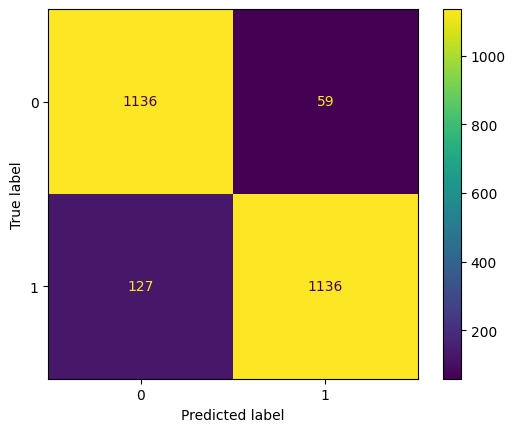

In [18]:
import numpy as np
y_pred_labels = []
y_true_labels = []

for x_batch, y_batch in test_ds:
    y_pred_batch = model.predict(x_batch)
    y_pred_labels.extend(np.argmax(y_pred_batch, axis=1))
    y_true_labels.extend(y_batch.numpy())

# 混同行列を表示
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
